## Libraries and modules

In [1]:
import tensorflow as tf
#AUTOTUNE adjusts dynamically the number of threads used by the operation
AUTOTUNE = tf.data.experimental.AUTOTUNE
print(f"Tensorflow ver. {tf.__version__}")

Tensorflow ver. 2.15.0


In [4]:
print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices('GPU'))

/device:GPU:0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-02-19 12:53:07.526291: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-02-19 12:53:07.526322: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-02-19 12:53:07.526327: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-02-19 12:53:07.526695: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-19 12:53:07.526939: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [2]:
import tensorflow_io as tfio

In [5]:
%matplotlib inline

import numpy as np
#from tifffile import imread, imsave
import cv2
from glob import glob
#import tqdm
from matplotlib import pyplot as plt
from sklearn.feature_extraction import image
import skimage.io as io
from skimage import util
import datetime, os
%run -i helperfunctions.py   # helper functions are in helperfunctions.py


In [6]:


#Load TensorBoard notebook extension
%load_ext tensorboard


# Creating our Dataloader

In [7]:
#Set seed to have fixed random numbers
SEED=42

#Add the paths
dataset_path = "dataTraining/"
training_data = "train/"
val_data = "validation/"
test_data = "test/"

In [8]:
# Image size that we are going to use, when using shape (2048,2048,3). Since functions have been
# moved to an external file, one nees to provide the image size in the external file.
#IMG_SIZE = 128
IMG_SIZE = 256

# Our images are RGB (3 channels)
N_CHANNELS = 3

# Scene Parsing has 2 classes 
N_CLASSES = 3

## Creating a source dataset

In [9]:
TRAINSET_SIZE = len(glob(dataset_path + training_data + "images/" + "*.png"))
print(f"The Training Dataset contains {TRAINSET_SIZE} images.")

VALSET_SIZE = len(glob(dataset_path + val_data + "images/" "*.png"))
print(f"The Validation Dataset contains {VALSET_SIZE} images.")

TESTSET_SIZE = len(glob(dataset_path + test_data + "images/" "*.png"))
print(f"The Test Dataset contains {TESTSET_SIZE} images.")

The Training Dataset contains 87 images.
The Validation Dataset contains 29 images.
The Test Dataset contains 6 images.


## Extra transformations
It uses helper functions defined in the helperfunctions.py

In [10]:
train_dataset = tf.data.Dataset.list_files(dataset_path + training_data + "images/" + "*.png", seed=SEED)
train_dataset = train_dataset.map(parse_image)

val_dataset = tf.data.Dataset.list_files(dataset_path + val_data + "images/" + "*.png", seed=SEED)
val_dataset =val_dataset.map(parse_image)

test_dataset = tf.data.Dataset.list_files(dataset_path + test_data + "images/" + "*.png", seed=SEED)
test_dataset =test_dataset.map(parse_image)

2024-02-19 12:53:26.560632: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-19 12:53:26.560681: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Implementation

In [11]:
import tensorflow.keras
from tensorflow.keras import Input 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, concatenate
#from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import Adam


This is a **U-Net** architecture, a type of Convolutional Neural Network (CNN) used for image segmentation tasks. It's called U-Net because of its U-shaped structure.

The architecture consists of two parts: an **encoder** (contracting path) and a **decoder** (expanding path).

**Encoder**: The encoder is a typical CNN that consists of convolutional layers and max pooling layers. It's used to capture the context in the image. The number of channels are doubled after each maxpool operation. This part of the network allows us to understand the features at different levels of abstraction.

**Bridge**: The bridge connects the encoder and decoder. It consists of two convolutional layers.

**Decoder**: The decoder is used to enable precise localization using transposed convolutions. Here, the feature map is upsampled and concatenated with a correspondingly cropped feature map from the encoder path, followed by two regular convolutions.

**Final Layer**: The final layer is a convolutional layer that maps each 64-component feature vector to the desired number of classes.

In the given code, the input image goes through the encoder, the bridge and then the decoder to output a segmentation map of the same size as the input. The activation function used is 'relu' in the encoder and decoder, and 'softmax' in the final layer. The 'softmax' activation function is used to generate probabilities for the output classes.

The initializer used for the weights in the convolutional layers is not specified in the selected code. The initializer determines how the weights are set in your model and can affect how quickly the model converges, or whether it converges at all.

**Initializer**
- He initialization works better for layers with ReLu activation.
- Xavier initialization works better for layers with sigmoid activation.


In [12]:
# -- Keras Functional API -- #
# -- UNet Implementation -- #
# Everything here is from tensorflow.keras.layers
# I imported tensorflow.keras.layers * to make it easier to read
# dropout regularization technique where randomly selected neurons are ignored during training, prevents overfitting
dropout_rate = 0.5
#size of image
input_size = (IMG_SIZE, IMG_SIZE, N_CHANNELS)

# If you want to know more about why we are using `he_normal`:
# https://stats.stackexchange.com/questions/319323/whats-the-difference-between-variance-scaling-initializer-and-xavier-initialize/319849#319849  
# Or the excellent fastai course:
# https://github.com/fastai/course-v3/blob/master/nbs/dl2/02b_initializing.ipynb
initializer = 'he_normal'


# -- Encoder -- #
# Block encoder 1
inputs = Input(shape=input_size)
conv_enc_1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=initializer)(inputs)
conv_enc_1 = Conv2D(64, 3, activation = 'relu', padding='same', kernel_initializer=initializer)(conv_enc_1)

# Block encoder 2
max_pool_enc_2 = MaxPooling2D(pool_size=(2, 2))(conv_enc_1)
conv_enc_2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(max_pool_enc_2)
conv_enc_2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_enc_2)

# Block  encoder 3
max_pool_enc_3 = MaxPooling2D(pool_size=(2, 2))(conv_enc_2)
conv_enc_3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(max_pool_enc_3)
conv_enc_3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_enc_3)

# Block  encoder 4
max_pool_enc_4 = MaxPooling2D(pool_size=(2, 2))(conv_enc_3)
conv_enc_4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(max_pool_enc_4)
conv_enc_4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_enc_4)
# -- Encoder -- #

# ----------- #
# maxpooling allows the network to learn increasingly abstract features at each layer
maxpool = MaxPooling2D(pool_size=(2, 2))(conv_enc_4)
conv = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(maxpool)
conv = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv)
# ----------- #

# -- Decoder -- #
# Block decoder 1
up_dec_1 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv))
merge_dec_1 = concatenate([conv_enc_4, up_dec_1], axis = 3)
conv_dec_1 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(merge_dec_1)
conv_dec_1 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_1)

# Block decoder 2
up_dec_2 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv_dec_1))
merge_dec_2 = concatenate([conv_enc_3, up_dec_2], axis = 3)
conv_dec_2 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(merge_dec_2)
conv_dec_2 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_2)

# Block decoder 3
up_dec_3 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv_dec_2))
merge_dec_3 = concatenate([conv_enc_2, up_dec_3], axis = 3)
conv_dec_3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(merge_dec_3)
conv_dec_3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_3)

# Block decoder 4
up_dec_4 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv_dec_3))
merge_dec_4 = concatenate([conv_enc_1, up_dec_4], axis = 3)
conv_dec_4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(merge_dec_4)
conv_dec_4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_4)
conv_dec_4 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_4)
# -- Dencoder -- #

output = Conv2D(N_CLASSES, 1, activation = 'softmax')(conv_dec_4)

# Train model

This Python code is using TensorFlow to prepare training and validation datasets for a machine learning model, and then defining and compiling the model.

Here's a breakdown:

1. **BATCH_SIZE and BUFFER_SIZE**: These are hyperparameters for the training process. BATCH_SIZE is the number of samples that will be passed through the model at once. BUFFER_SIZE is used in shuffling the dataset; it determines how many samples from the dataset the shuffling algorithm will hold in its buffer at once.

2. **Dataset Preparation**: The code prepares both the training and validation datasets. It applies a function (`load_image_train` or `load_image_test`) to each item in the datasets, shuffles the training dataset, repeats the datasets (so they can be iterated over multiple times), groups the datasets into batches, and sets them up to load data in the background while the model is training.

3. **Model Definition and Compilation**: The model is defined with a certain structure (not shown in the selected code) and compiled. The Adam optimizer is used with a learning rate of 0.0001. The loss function is categorical cross-entropy, which is commonly used for multi-class classification problems. The model will also track accuracy as a metric during training.

The `tf.data.experimental.AUTOTUNE` argument allows TensorFlow to dynamically adjust the number of parallel calls during execution, optimizing throughput.

The `print` statements at the end are used to display information about the final training and validation datasets.

More about `BATCH_SIZE` parameter in machine learning models, particularly in deep learning, refers to the number of training examples utilized in one iteration. In the context of your code, `BATCH_SIZE = 2` means that your model will take in 2 images at a time during training or validation.

Here are some reasons why batching is used:

1. **Memory Usage**: If you have a large dataset, it might not fit into your machine's memory all at once. By dividing the data into smaller batches, you can train on a subset of the data, which reduces the amount of memory needed.

2. **Training Speed**: Training on batches can be faster than training on individual examples because modern libraries can parallelize the operations to run on a GPU.

3. **Convergence**: Batching can help to stabilize training by providing a smoother estimate of the gradient. Instead of updating weights based on one example at a time (which can be noisy), you update based on the average gradient over a batch of examples.

4. **Generalization**: Training on batches adds some noise to the learning process, which can prevent overfitting and help the model generalize better.

Remember, choosing the right batch size is a trade-off. Larger batches can lead to faster training, but too large can exceed your memory or lead to poor generalization. Smaller batches can lead to slower training and noisier gradient estimates, but can sometimes converge faster.



In [13]:
BATCH_SIZE = 4
# for reference about the BUFFER_SIZE in shuffle:
# https://stackoverflow.com/questions/46444018/meaning-of-buffer-size-in-dataset-map-dataset-prefetch-and-dataset-shuffle

BUFFER_SIZE = 1000 #affects the randomness of dataset, hence the order in which elements are produced.

dataset = {"train": train_dataset, "val": val_dataset}

# -- Train Dataset --#
#it already includes data augmentation
#dataset['train'] = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset['train'] = dataset['train'].map(lambda x: load_image_train(x, IMG_SIZE), num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset['train'] = dataset['train'].shuffle(buffer_size=BUFFER_SIZE, seed=SEED)
dataset['train'] = dataset['train'].repeat()
dataset['train'] = dataset['train'].batch(BATCH_SIZE)
dataset['train'] = dataset['train'].prefetch(buffer_size=AUTOTUNE)

#-- Validation Dataset --#
#dataset['val'] = dataset['val'].map(load_image_test)
dataset['val'] = dataset['val'].map(lambda x: load_image_test(x, IMG_SIZE))
dataset['val'] = dataset['val'].repeat()
dataset['val'] = dataset['val'].batch(BATCH_SIZE)
dataset['val'] = dataset['val'].prefetch(buffer_size=AUTOTUNE)

print(dataset['train'])
print(dataset['val'])


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))>


In [20]:

# model
model = tf.keras.Model(inputs = inputs, outputs = output)
# model.compile(optimizer=Adam(learning_rate=0.0001), loss = tf.keras.losses.CategoricalCrossentropy(),
#               metrics=['accuracy'])
model.compile(optimizer=Adam(learning_rate=0.0001), loss = tf.keras.losses.CategoricalCrossentropy(),
               metrics=['accuracy'])

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

## Training
### Simple loop

In [21]:
EPOCHS = 1

STEPS_PER_EPOCH = TRAINSET_SIZE // BATCH_SIZE
VALIDATION_STEPS = VALSET_SIZE // BATCH_SIZE
# sometimes it can be very interesting to run some batches on cpu
# because the tracing is way better than on GPU
# you will have more obvious error message
# but in our case, it takes A LOT of time

# On CPU
#with tf.device("/cpu:0"):
#    model_history = model.fit(dataset['train'], epochs=EPOCHS,
#                              steps_per_epoch=STEPS_PER_EPOCH,
#                              validation_steps=VALIDATION_STEPS,
#                              validation_data=dataset['val'])

# On GPU
model_history = model.fit(dataset['train'], epochs=EPOCHS,
                           steps_per_epoch=STEPS_PER_EPOCH,
                           validation_steps=VALIDATION_STEPS,
                           validation_data=dataset['val'])

21/21 [==============================] - 17s 517ms/step - loss: 409.0106 - accuracy: 0.9937 - val_loss: 9769.6104 - val_accuracy: 1.0000


### Advanced training

In [32]:
# model
model = tf.keras.Model(inputs = inputs, outputs = output)
model.compile(optimizer=Adam(learning_rate=0.0001), loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
#logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [33]:
#suggested by copilot 10-20 epochs
EPOCHS = 50

STEPS_PER_EPOCH = TRAINSET_SIZE // BATCH_SIZE
VALIDATION_STEPS = VALSET_SIZE // BATCH_SIZE
# sometimes it can be very interesting to run some batches on cpu
# because the tracing is way better than on GPU
# you will have more obvious error message
# but in our case, it takes A LOT of time

# On CPU
#with tf.device("/cpu:0"):
#    model_history = model.fit(dataset['train'], epochs=EPOCHS,
#                              steps_per_epoch=STEPS_PER_EPOCH,
#                              validation_steps=VALIDATION_STEPS,
#                              validation_data=dataset['val'])

# On GPU
model_history = model.fit(dataset['train'], epochs=EPOCHS,
                           steps_per_epoch=STEPS_PER_EPOCH,
                           validation_steps=VALIDATION_STEPS,
                           validation_data=dataset['val'])

Epoch 1/50
21/21 [==============================] - 17s 514ms/step - loss: 0.0661 - accuracy: 0.9942 - val_loss: 0.0475 - val_accuracy: 0.9958
Epoch 2/50
21/21 [==============================] - 13s 632ms/step - loss: 0.0671 - accuracy: 0.9907 - val_loss: 0.0511 - val_accuracy: 0.9863
Epoch 3/50
21/21 [==============================] - 11s 504ms/step - loss: 0.0610 - accuracy: 0.9868 - val_loss: 0.0499 - val_accuracy: 0.9889
Epoch 4/50
21/21 [==============================] - 13s 605ms/step - loss: 0.0681 - accuracy: 0.9850 - val_loss: 0.0502 - val_accuracy: 0.9862
Epoch 5/50
21/21 [==============================] - 11s 523ms/step - loss: 0.0618 - accuracy: 0.9847 - val_loss: 0.0498 - val_accuracy: 0.9849
Epoch 6/50
21/21 [==============================] - 11s 524ms/step - loss: 0.0701 - accuracy: 0.9817 - val_loss: 0.0509 - val_accuracy: 0.9863
Epoch 7/50
21/21 [==============================] - 11s 503ms/step - loss: 0.0608 - accuracy: 0.9846 - val_loss: 0.0500 - val_accuracy: 0.9878

In [17]:
#%tensorboard --logdir logs

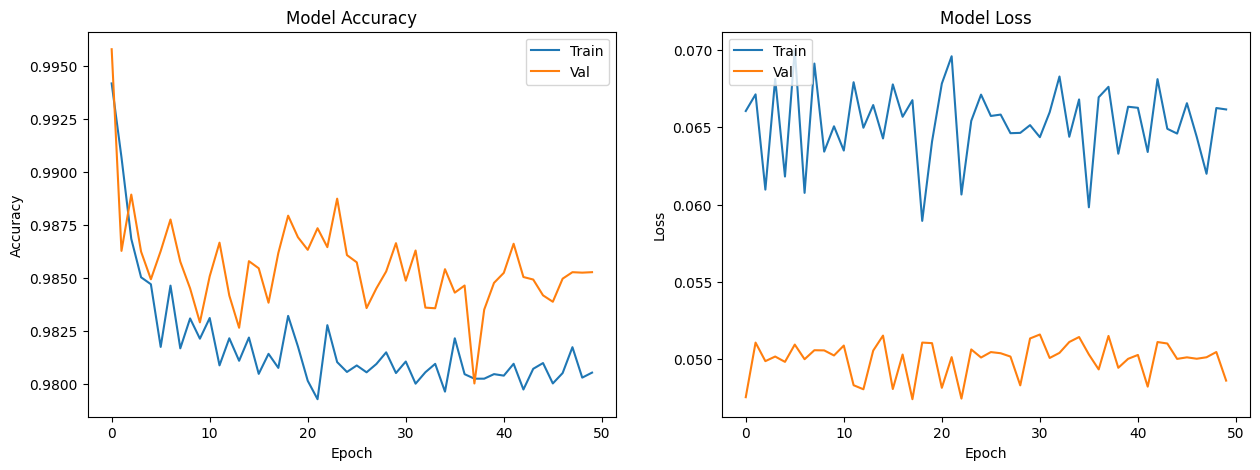

In [34]:
import matplotlib.pyplot as plt
f = plt.figure(figsize=(15,5))
ax = f.add_subplot(121)
ax.plot(model_history.history['accuracy'])
ax.plot(model_history.history['val_accuracy'])
ax.set_title('Model Accuracy')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.legend(['Train', 'Val'])

ax2 = f.add_subplot(122)

ax2.plot(model_history.history['loss'])
ax2.plot(model_history.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Val'],loc= 'upper left')

plt.show()

1/1 [==============================] - 0s 338ms/step


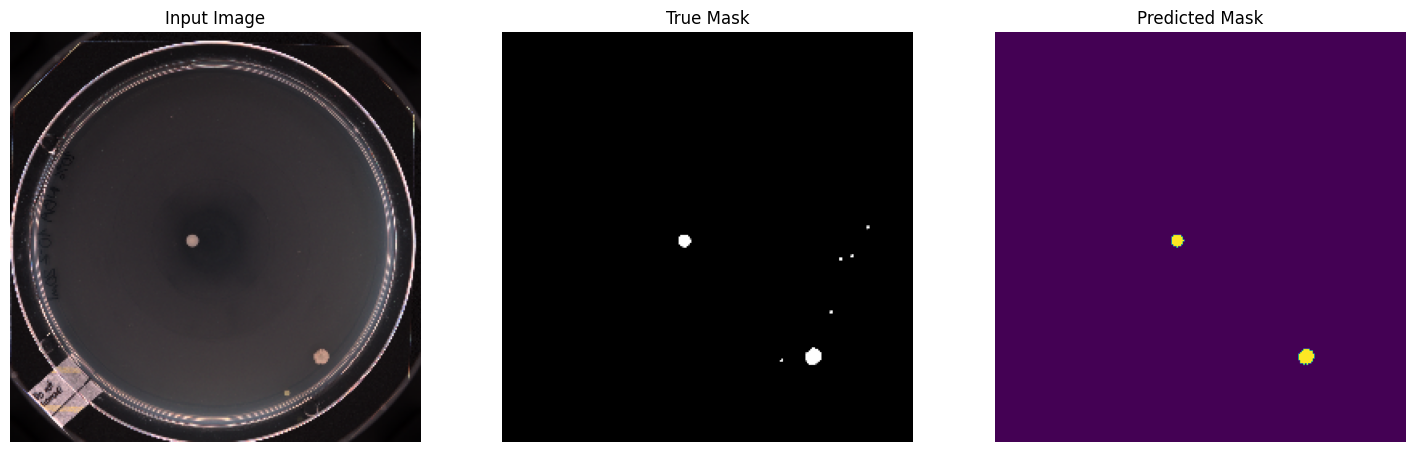

In [35]:
for image, mask in dataset['val'].take(1):
    sample_image, sample_mask = image, mask
show_predictions()


In [20]:
model_history.history

{'loss': [0.06800611317157745,
  0.06368644535541534,
  0.06546138226985931,
  0.06590975821018219,
  0.06564018875360489,
  0.06371726840734482,
  0.06700262427330017,
  0.06302446126937866,
  0.06343990564346313,
  0.06733597815036774,
  0.06390747427940369,
  0.06555841118097305,
  0.06652451306581497,
  0.06827258318662643,
  0.06057601049542427,
  0.06825268268585205,
  0.06609572470188141,
  0.06179346889257431,
  0.06764854490756989,
  0.06392364203929901,
  0.06223735213279724,
  0.06595207750797272,
  0.06740841269493103,
  0.06425794214010239,
  0.06644240021705627,
  0.06606104969978333,
  0.06355699151754379,
  0.06722545623779297,
  0.06670116633176804,
  0.05982499197125435,
  0.0678907185792923,
  0.064699187874794,
  0.06721000373363495,
  0.0654093399643898,
  0.06091923639178276,
  0.06881345808506012,
  0.06312448531389236,
  0.06613223999738693,
  0.06639817357063293,
  0.060517240315675735,
  0.06827444583177567,
  0.06874150037765503,
  0.061873216181993484,
  0.0

In [21]:
#model.save('model_122images_50epochs.h5')

### Testing

In [22]:
#model = tf.keras.models.load_model('model_49images.h5')
#model.summary()

In [23]:
# IMG_SIZE = 256
# dataset = {"test": test_dataset}

# #-- Validation Dataset --#
# #dataset['test'] = dataset['test'].map(load_image_test)
# dataset['test'] = dataset['test'].map(lambda x: load_image_test(x, IMG_SIZE))
# dataset['test'] = dataset['test'].repeat()
# dataset['test'] = dataset['test'].batch(BATCH_SIZE)
# dataset['test'] = dataset['test'].prefetch(buffer_size=AUTOTUNE)

# print(dataset['test'])

In [24]:
# for image, mask in dataset['test'].take(1):
#     sample_image, sample_mask = image, mask
# show_predictions()

In [25]:
for image, mask in dataset['test'].take(1):
    sample_image, sample_mask = image, mask
calculate_colonies()

KeyError: 'test'

So for it seems it has difficulties to find small colonies, could this be due to the low contrast image that I get after loading.